In [1]:
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import random

import torch 
from torchvision import datasets , transforms
from torch.utils.data import DataLoader
import torch.nn as nn

import torch.nn.functional as F
from torch import optim

from tqdm import tqdm
import copy

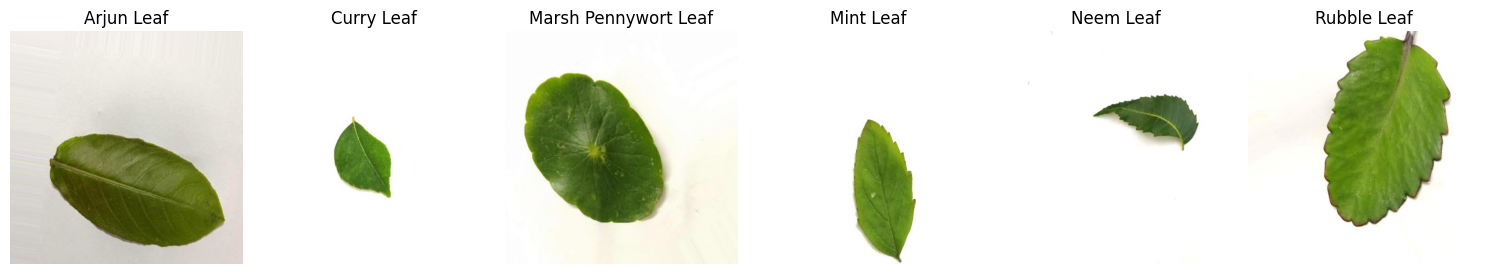

In [2]:
train_dir = r"../Medicinal Plant Identification Dataset/Augmented Images (Version 02)"
classes = [d for d in os.listdir(train_dir) if os.path.isdir(os.path.join(train_dir, d))]
plt.figure(figsize=(15, 8))
for i, cls in enumerate(classes):
    cls_path = os.path.join(train_dir, cls)
    images = glob.glob(os.path.join(cls_path, '*.jpg'))  # Get path following the specified pattern
    if images:
        img_path = random.choice(images)
        img = mpimg.imread(img_path)
        plt.subplot(1, len(classes), i+1)
        plt.imshow(img)
        plt.title(cls)
        plt.axis('off')
plt.tight_layout()
plt.show()

In [3]:
# defining transformers
IMG_SIZE = (224, 224)

transform = transforms.Compose([
    transforms.Resize(IMG_SIZE),
    transforms.ToTensor()
])

In [4]:
# Creating Custome dataset
train_dir = r"../Medicinal Plant Identification Dataset/Augmented Images (Version 02)"
test_dir = r"../Medicinal Plant Identification Dataset/Original Images (Version 02)"
val_dir = r"../Medicinal Plant Identification Dataset/Validation Images"

train_data = datasets.ImageFolder(train_dir , transform=transform)
test_data = datasets.ImageFolder(test_dir ,  transform=transform)
val_data = datasets.ImageFolder(val_dir ,  transform=transform)

no_of_classes = len(train_data.classes)

print(f"Train set have {len(train_data)} samples belonging to {no_of_classes} ")
print(f"Test set have {len(test_data)} samples belonging to {no_of_classes} ")
print(f"Validation set have {len(val_data)} samples belonging to {no_of_classes} ")

print('\n')
# printing labels
print(train_data.class_to_idx)

Train set have 9660 samples belonging to 6 
Test set have 1380 samples belonging to 6 
Validation set have 276 samples belonging to 6 


{'Arjun Leaf': 0, 'Curry Leaf': 1, 'Marsh Pennywort Leaf': 2, 'Mint Leaf': 3, 'Neem Leaf': 4, 'Rubble Leaf': 5}


In [5]:
# Create Data Loader
BATCH_SIZE = 32

train_loader = DataLoader(train_data , batch_size=BATCH_SIZE  , shuffle=True , num_workers=3)
test_loader = DataLoader(test_data , batch_size=BATCH_SIZE  , shuffle=False , num_workers=3)
val_loader = DataLoader(val_data , batch_size=BATCH_SIZE  , shuffle=False , num_workers=3)

In [6]:
# Model Definition

class CNNetwork(nn.Module):

    def __init__(self , in_channels , num_classes):
        # in_channels : number of channels in RGB 3 in gryscale 1
        # num_classes : number of output classes
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=in_channels , out_channels=32 , kernel_size=(3,3) , padding=1)
        self.conv2 = nn.Conv2d(in_channels=32 , out_channels=64 , kernel_size=(3,3) , padding=1)
        self.conv3 = nn.Conv2d(in_channels=64 , out_channels=128 , kernel_size=(3,3) , padding=1)

        self.maxPool = nn.MaxPool2d(kernel_size=2 , stride=2 , padding=0)

        # calcualte flattened zise dynamically
        with torch.no_grad():
            dummy_input = torch.zeros(1, in_channels, 224, 224) 
            x = self.maxPool(F.relu(self.conv1(dummy_input)))
            x = self.maxPool(F.relu(self.conv2(x)))
            x = self.maxPool(F.relu(self.conv3(x)))
            self.flattened_size = x.numel() # Get the number of elements in the tensor

        self.fc1 = nn.Linear(self.flattened_size , 128)
        self.fc2 = nn.Linear(128 , 64)
        self.fc3 = nn.Linear(64 , num_classes)


    def forward(self , x):
        x  = F.relu(self.conv1(x))
        x  = self.maxPool(x)

        x  = F.relu(self.conv2(x))
        x  = self.maxPool(x)

        x  = F.relu(self.conv3(x))
        x  = self.maxPool(x)

        x = torch.flatten(x  , 1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

model = CNNetwork(in_channels=3 , num_classes=6)
print(model)

CNNetwork(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (maxPool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=6, bias=True)
)


In [7]:
# calucate trainable paramters
total  = 0
for parameter in model.parameters():
    total += parameter.numel()

print(total)

12947078


In [9]:
# Training loop

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 15
# Early stopping parameters
patience = 2
min_delta = 0
best_val_loss = float('inf')
counter = 0

num_epochs = 10
for epoch in range(num_epochs):
    print(f"Epoch [{epoch + 1}/{num_epochs}]")

    # Training loop
    model.train()
    for batch_index, (data, targets) in enumerate(tqdm(train_loader)):
        data = data.to(device)
        targets = targets.to(device)
        scores = model(data)
        loss = criterion(scores, targets)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Validation loop
    model.eval()
    val_loss = 0
    with torch.no_grad():
        for data_val, targets_val in val_loader:
            data_val = data_val.to(device)
            targets_val = targets_val.to(device)
            scores_val = model(data_val)
            loss_val = criterion(scores_val, targets_val)
            val_loss += loss_val.item()
    
    val_loss /= len(val_loader)
    print(f"Validation Loss: {val_loss:.4f}")

    # Early stopping check
    if val_loss < best_val_loss - min_delta:
        best_val_loss = val_loss
        counter = 0
        # Save the best model
        best_model_wts = copy.deepcopy(model.state_dict())
    else:
        counter += 1
        print(f"EarlyStopping counter: {counter} of {patience}")
        if counter >= patience:
            print("Early stopping triggered. Restoring best model weights.")
            model.load_state_dict(best_model_wts)
            break

print('Training finished. Best model restored.')


Epoch [1/10]


  0%|          | 0/302 [00:00<?, ?it/s]

100%|██████████| 302/302 [08:44<00:00,  1.74s/it]


Validation Loss: 0.2070
Epoch [2/10]


100%|██████████| 302/302 [08:15<00:00,  1.64s/it]


Validation Loss: 0.0764
Epoch [3/10]


100%|██████████| 302/302 [08:26<00:00,  1.68s/it]


Validation Loss: 0.0579
Epoch [4/10]


100%|██████████| 302/302 [08:16<00:00,  1.65s/it]


Validation Loss: 0.1305
EarlyStopping counter: 1 of 2
Epoch [5/10]


100%|██████████| 302/302 [08:07<00:00,  1.61s/it]


Validation Loss: 0.0714
EarlyStopping counter: 2 of 2
Early stopping triggered. Restoring best model weights.
Training finished. Best model restored.


In [23]:
# model evaluation
from torchmetrics.classification import Accuracy

acc = Accuracy(task="multiclass" , num_classes=6)

model.eval()

with torch.no_grad():
    for data , label in train_loader:
        data = data.to(device)
        label = label.to(device)

        # forward pass
        score = model(data)

        # get max score out of all
        _ , predicted = torch.max(score.data , 1)
        acc(predicted , label) 


train_accuracy = acc.compute()

In [ ]:
# model evaluation
from torchmetrics.classification import Accuracy

acc = Accuracy(task="multiclass" , num_classes=6)

model.eval()

with torch.no_grad():
    for data , label in test_loader:
        data = data.to(device)
        label = label.to(device)

        # forward pass
        score = model(data)

        # get max score out of all
        _ , predicted = torch.max(score.data , 1)
        acc(predicted , label) 


test_accuracy = acc.compute()

Test Accuracy : tensor(0.9812)


In [13]:
acc = Accuracy(task="multiclass" , num_classes=6)

model.eval()

with torch.no_grad():
    for data , label in val_loader:
        data = data.to(device)
        label = label.to(device)

        # forward pass
        score = model(data)

        # get max score out of all
        _ , predicted = torch.max(score.data , 1)
        acc(predicted , label) 


val_accuracy = acc.compute()

In [24]:
print(f"Train Accuracy : {(train_accuracy.item()*100):.2f}" )
print(f"Test Accuracy : {(test_accuracy.item()*100):.2f}" )
print(f"Validation Accuracy : {(val_accuracy.item()*100):.2f}")

Train Accuracy : 98.47
Test Accuracy : 98.12
Validation Accuracy : 98.55


In [25]:
# export model

torch.save(model , '../artifacts/models/torch_model.pth')
torch.save(model , '../artifacts/models/torch_model.pt')